In [2]:
from dotenv import load_dotenv
load_dotenv()


False

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
import os
from huggingface_hub import login

login(token=os.getenv("HF_TOKEN"))


In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import tensorflow as tf


In [ ]:
MODEL_TYPE = "bert"   # change to "lstm" if you prefer the LSTM route
DATA_DIR = "/content" # change if you mount drive elsewhere
SAVE_DIR = "/content/saved_model"


In [ ]:
from google.colab import drive

In [ ]:
# 4. Load datasets (make sure train.csv & test.csv are uploaded to Colab or provide full paths)
train_path = os.path.join(DATA_DIR, "train.csv")
test_path  = os.path.join(DATA_DIR, "test.csv")
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
print("Train:", train_df.shape, "Test:", test_df.shape)
display(train_df.head())

Train: (159571, 8) Test: (153164, 2)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# 5. Quick EDA
label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
if not set(label_cols).issubset(train_df.columns):
    # If your dataset uses only 'toxic' label, adjust:
    available = [c for c in train_df.columns if c not in ['id','comment_text']]
    print("Detected label columns:", available)
else:
    print("Using 6-label multi-label classification.")
print(train_df[label_cols].sum())

Using 6-label multi-label classification.
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


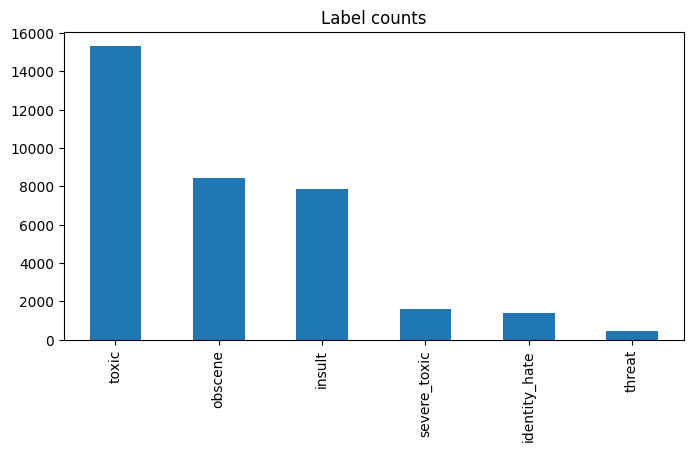

In [ ]:
# Plot label distribution (binary counts)
plt.figure(figsize=(8,4))
(train_df[label_cols].sum()).sort_values(ascending=False).plot(kind='bar')
plt.title("Label counts")
plt.show()

In [ ]:
# 6. Preprocessing helpers
import tensorflow.keras.preprocessing.text as kpt
from tensorflow.keras.preprocessing.sequence import pad_sequences

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+","",text)        # remove urls
    text = re.sub(r"[^a-zA-Z0-9\s]"," ", text)     # keep alpha-numeric
    text = re.sub(r"\s+"," ", text).strip()
    return text

train_df['comment_text'] = train_df['comment_text'].fillna("unknown").apply(clean_text)
test_df['comment_text']  = test_df['comment_text'].fillna("unknown").apply(clean_text)


In [ ]:
# 7. Prepare labels (use multi-label if available)
if set(label_cols).issubset(train_df.columns):
    y = train_df[label_cols].values
else:
    # fallback: use single 'toxic' label if present
    if 'toxic' in train_df.columns:
        y = train_df['toxic'].values
        label_cols = ['toxic']
    else:
        raise ValueError("No known label columns found. Update label_cols or dataset.")

X = train_df['comment_text'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 8a. LSTM pipeline (if selected)
if MODEL_TYPE.lower() == "lstm":
    # Tokenize
    max_words = 50000
    max_len = 150
    tokenizer = kpt.Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
    X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

    # Build model
    embedding_dim = 128
    inputs = tf.keras.Input(shape=(max_len,))
    x = tf.keras.layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len)(inputs)
    x = tf.keras.layers.SpatialDropout1D(0.2)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
    x = tf.keras.layers.GlobalMaxPool1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    if len(label_cols) == 1:
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'
        metrics = ['accuracy']
    else:
        outputs = tf.keras.layers.Dense(len(label_cols), activation='sigmoid')(x)
        loss = 'binary_crossentropy'  # multi-label => binary crossentropy
        metrics = ['accuracy']
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=loss, metrics=metrics)
    model.summary()

    # Train
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=3,                  # increase if you want
        batch_size=128
    )

    # Save tokenizer + model
    os.makedirs(SAVE_DIR, exist_ok=True)
    # Save tokenizer (as json)
    import json
    tokenizer_json = tokenizer.to_json()
    with open(os.path.join(SAVE_DIR, "tokenizer.json"), "w") as f:
        f.write(tokenizer_json)
    model.save(os.path.join(SAVE_DIR, "lstm_model.h5"))
    print("Saved LSTM model and tokenizer to", SAVE_DIR)

    # Evaluate
    preds = model.predict(X_val_pad)
    if preds.shape[1] if len(preds.shape)>1 else 1:
        # multi-label or single
        if len(label_cols) == 1:
            y_pred = (preds>0.5).astype(int)
            print(classification_report(y_val, y_pred))
        else:
            y_pred = (preds>0.5).astype(int)
            print(classification_report(y_val, y_pred, target_names=label_cols))


In [ ]:
# 8b. DistilBERT pipeline (if selected)
if MODEL_TYPE.lower() == "lstm":
    pass
elif MODEL_TYPE.lower() == "bert":
    # HuggingFace fine-tune using Trainer (PyTorch) with DistilBERT
    import os
    import torch
    import numpy as np
    import pandas as pd
    from sklearn.metrics import classification_report
    from transformers import AutoTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer
    from datasets import Dataset, DatasetDict

    # ✅ Use prajjwal1/bert-tiny (lighter & faster)
    model_name = "prajjwal1/bert-tiny"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenization function
    def tokenize_fn(examples):
        return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=64)

    # Prepare train/val DataFrames
    if len(label_cols) == 1:  # single-label
        df_train = pd.DataFrame({"text": X_train, "label": y_train})
        df_val   = pd.DataFrame({"text": X_val,   "label": y_val})
    else:  # multi-label
        df_train = pd.DataFrame({"text": X_train, "label": list(y_train)})
        df_val   = pd.DataFrame({"text": X_val,   "label": list(y_val)})

    # Convert to HuggingFace datasets
    ds_train = Dataset.from_pandas(df_train)
    ds_val   = Dataset.from_pandas(df_val)
    ds = DatasetDict({"train": ds_train, "validation": ds_val})
    ds = ds.map(tokenize_fn, batched=True)

    # Define DistilBERT model
    if len(label_cols) == 1:   # binary classification
        model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
    else:  # multi-label classification
        model = DistilBertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=len(label_cols),
            problem_type="multi_label_classification"
        )

    # TrainingArguments
    training_args = TrainingArguments(
        output_dir="/content/distilbert_output",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        logging_strategy="steps",
        logging_steps=20,
        eval_strategy="steps",   # ✅ fixed name
        eval_steps=100,
        save_strategy="steps",
        save_steps=100,
        num_train_epochs=0.1,  # increase if Colab runtime allows
        max_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        seed=42,
        fp16=torch.cuda.is_available()  # ✅ use mixed precision if GPU supports it
    )

    # Compute metrics
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        if len(label_cols) == 1:  # single-label
            preds = np.argmax(logits, axis=-1)
            return {"accuracy": (preds == labels).mean()}
        else:  # multi-label
            probs = torch.sigmoid(torch.tensor(logits)).numpy()
            preds = (probs > 0.5).astype(int)
            report = classification_report(labels, preds, output_dict=True, zero_division=0)
            return {"micro-f1": report.get("micro avg", {}).get("f1-score", 0)}

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=ds["train"],
        eval_dataset=ds["validation"],
        compute_metrics=compute_metrics
    )

    # Train
    trainer.train()

    # Save model + tokenizer
    os.makedirs(SAVE_DIR, exist_ok=True)
    trainer.save_model(SAVE_DIR)
    tokenizer.save_pretrained(SAVE_DIR)
    print("✅ Saved DistilBERT model + tokenizer to", SAVE_DIR)

    # Final evaluation on validation
    val_texts = list(df_val["text"])
    val_enc = tokenizer(val_texts, truncation=True, padding=True, return_tensors="pt", max_length=128)
    model.eval()
    with torch.no_grad():

      inputs = {k: v.to(model.device) for k, v in val_enc.items() if k != "token_type_ids"}
      out = model(**inputs)
      logits = out.logits.cpu().numpy()


    if len(label_cols) == 1:
        preds = np.argmax(logits, axis=-1)
        print(classification_report(df_val[label_cols[0]], preds))
    else:
        probs = 1 / (1 + np.exp(-logits))
        preds = (probs > 0.5).astype(int)
        print(classification_report(df_val[label_cols].values, preds, target_names=label_cols))

else:
    raise ValueError("MODEL_TYPE must be 'lstm' or 'bert'")

Map:   0%|          | 0/127656 [00:00<?, ? examples/s]

Map:   0%|          | 0/31915 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.word_embeddings.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin2.bias', 'distilbert.transformer.layer.

Step,Training Loss,Validation Loss,Micro-f1
100,0.598300,0.589211,0.000000


✅ Saved DistilBERT model + tokenizer to /content/saved_model
